In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [5]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle
import scipy as sc
from scipy import signal

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

In [6]:
class bio_eq_nDDE_args(ndde.arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, adj_data_size = 2,
                 model_dir = 'Bio_nDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2000., nt = 4000, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                 Xi = 0.1, R_m = 1., Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30, 
                 bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3
        elif bio_model_low_complex == 'NPZD': state_dim = 4
        elif bio_model_low_complex == 'NNPZD': state_dim = 5

        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot, is_tstart_zero = is_tstart_zero)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_low_complex)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

In [7]:
args = bio_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 4, epochs = 350, learning_rate = 0.05, 
                        decay_rate = 0.97, test_freq = 1, plot_freq = 1, d_max = 4., rnn_nmax = 6+1, rnn_dt = 0.75, 
                        model_dir = 'Bio_nDDE_testcase_v3/model_dir_case2', restart = 0, val_percentage = 10.,
                        T = 30., nt = 600, z = -25, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., 
                        Psi = 1.46, Xi = 0.1, R_m = 1.52, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, 
                        Omega = 0.041, T_bio = 30., bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', 
                        ode_alg_name = 'dopri5', nsteps = 5)

## Load data

In [8]:
os.chdir(basedir)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDDE_C2_Exp3_predictions.pkl'), 'rb') as output:
    nDDE_dict = pickle.load(output)

In [9]:
t = tf.concat([nDDE_dict['t'], nDDE_dict['val_t']], axis=0)

nnpzd = tf.concat([nDDE_dict['true_x_low_complex'], nDDE_dict['val_true_x_low_complex']], axis=0)

npz = tf.concat([nDDE_dict['x_low_complex'], nDDE_dict['val_x_low_complex']], axis=0)

nDDE_pred = nDDE_dict['pred_y']

## Plot RMSE 

In [78]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(20, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=18)
        ax_x1.set_xlabel('t (Days)', fontsize=18)
        ax_x1.set_ylabel('Concentration', fontsize=18)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], '-r', label = 'N (High-fidelity)', linewidth = 2)
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 0], '--r', label = 'N (Low-fidelity)', dashes=(5, 5), linewidth = 2)
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], 'or', label = 'N (Learned)', markersize=5, markevery=20, linewidth = 2)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 1], '-g', label = 'P (High-fidelity)', linewidth = 2)
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 1], '--g', label = 'P (Low-fidelity)', dashes=(5, 5), linewidth = 2)
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 1], 'og', label = 'P (Learned)', markersize=5, markevery=20, linewidth = 2)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 2], '-b', label = 'Z (High-fidelity)', linewidth = 2)
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 2], '--b', label = 'Z (Low-fidelity)', dashes=(5, 5), linewidth = 2)
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 2], 'ob', label = 'Z (Learned)', markersize=5, markevery=20, linewidth = 2)

        ax_x1.set_xlim(self.t[0], self.t[-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.02,1.04), loc="upper left", prop={'size': 16})
        ax_x1.tick_params(axis='x', labelsize=16)
        ax_x1.tick_params(axis='y', labelsize=16)
        plt.gcf().set_dpi(300)
        
        plt.show() 
        
    def plot_npz(self, last=1200, epoch = 0):
        fig = plt.figure(figsize=(5, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=18)
        ax_x1.set_xlabel('t (Days)', fontsize=18)
        ax_x1.set_ylabel('Concentration', fontsize=18)
        ax_x1.plot(self.t.numpy()[0:last], self.y_no_nn.numpy()[0:last, 0, 0], '-r', label = 'Nutrients (N)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.y_no_nn.numpy()[0:last, 0, 1], '-g', label = 'Phyto. (P)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.y_no_nn.numpy()[0:last, 0, 2], '-b', label = 'Zoo. (Z)', linewidth = 2)

        ax_x1.set_xlim(self.t[0], self.t[last-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.02,1.04), loc="upper left", prop={'size': 16})
        ax_x1.tick_params(axis='x', labelsize=16)
        ax_x1.tick_params(axis='y', labelsize=16)

        plt.show()
        
    def plot_nnpzd(self, last=1200, epoch = 0):
        fig = plt.figure(figsize=(5, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=18)
        ax_x1.set_xlabel('t (Days)', fontsize=18)
        ax_x1.set_ylabel('Concentration', fontsize=18)
        ax_x1.plot(self.t.numpy()[0:last], self.true_y.numpy()[0:last, 0, 0], '-r', label = 'Nitrate ($NO_3$)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.true_y.numpy()[0:last, 0, 1], '-c', label = 'Ammonia ($NH_4$)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.true_y.numpy()[0:last, 0, 2], '-g', label = 'Phyto. (P)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.true_y.numpy()[0:last, 0, 3], '-b', label = 'Zoo. (Z)', linewidth = 2)
        ax_x1.plot(self.t.numpy()[0:last], self.true_y.numpy()[0:last, 0, 4], '-b', label = 'Detritus (D)', linewidth = 2)

        ax_x1.set_xlim(self.t[0], self.t[last-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.02,1.04), loc="upper left", prop={'size': 16})
        ax_x1.tick_params(axis='x', labelsize=16)
        ax_x1.tick_params(axis='y', labelsize=16)

        plt.show()

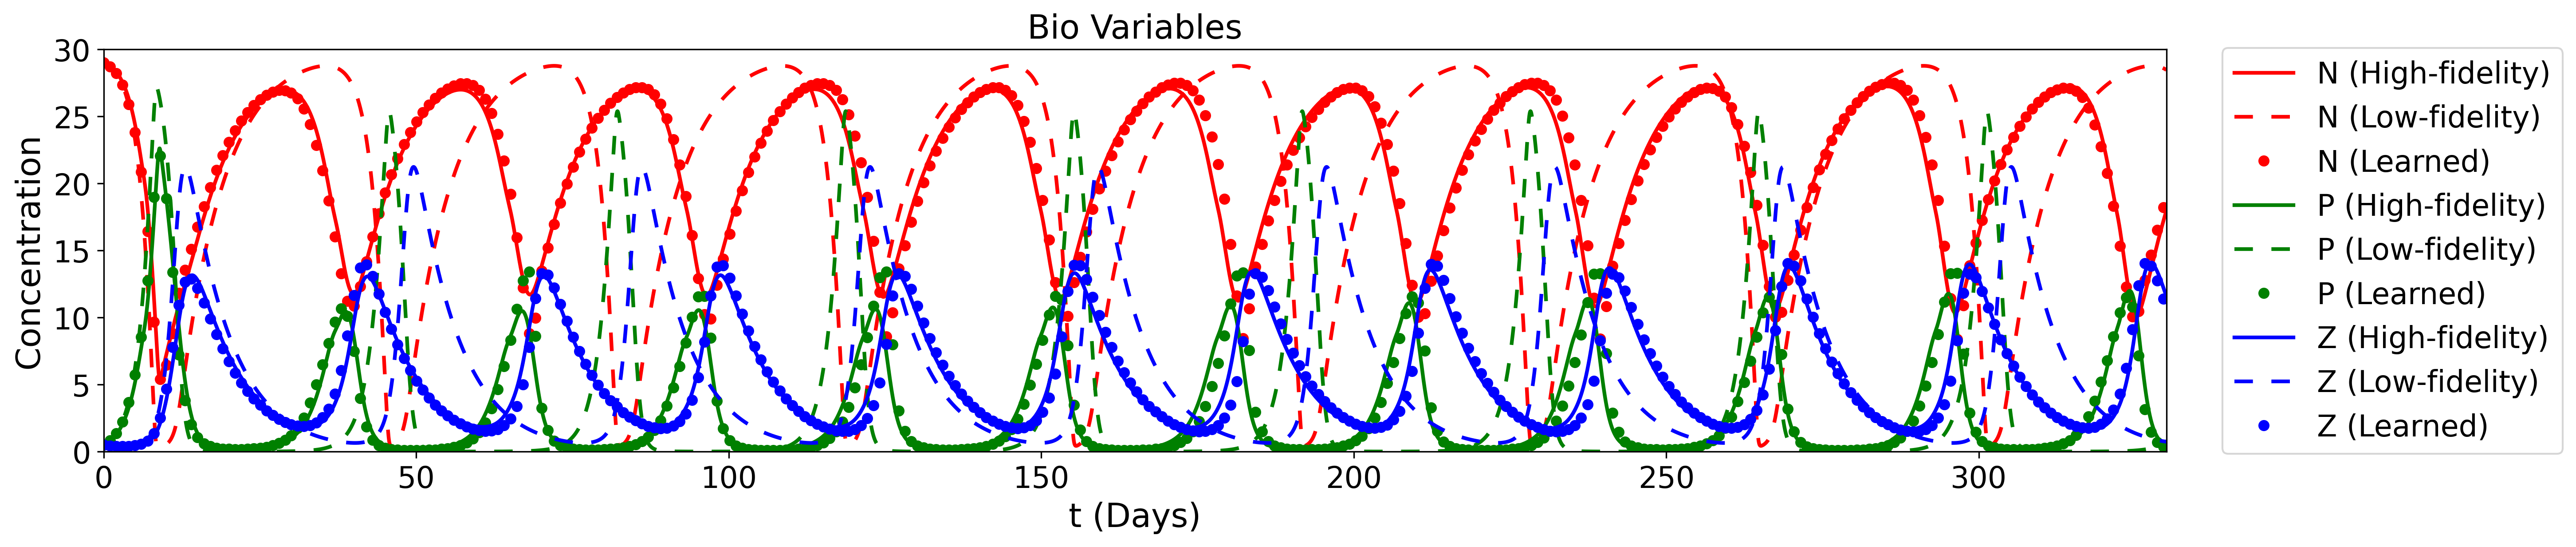

In [79]:
plot_obj = custom_plot(nnpzd, npz, t, args)
plot_obj.plot(nDDE_pred)

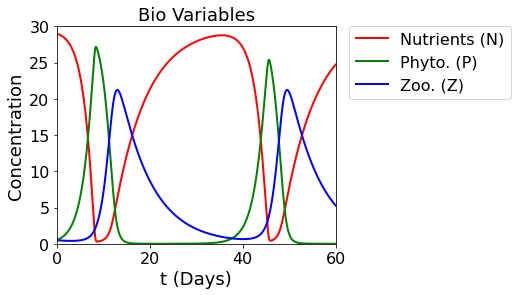

In [72]:
plot_obj.plot_npz()